In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier


In [22]:
df = pd.read_csv("Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [24]:
df.shape

(6362620, 11)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [26]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


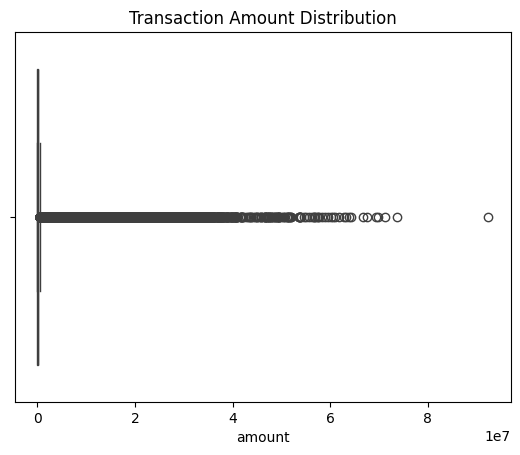

In [27]:
sns.boxplot(x=df['amount'])
plt.title("Transaction Amount Distribution")
plt.show()

In [28]:
df['amount_log'] = np.log1p(df['amount'])

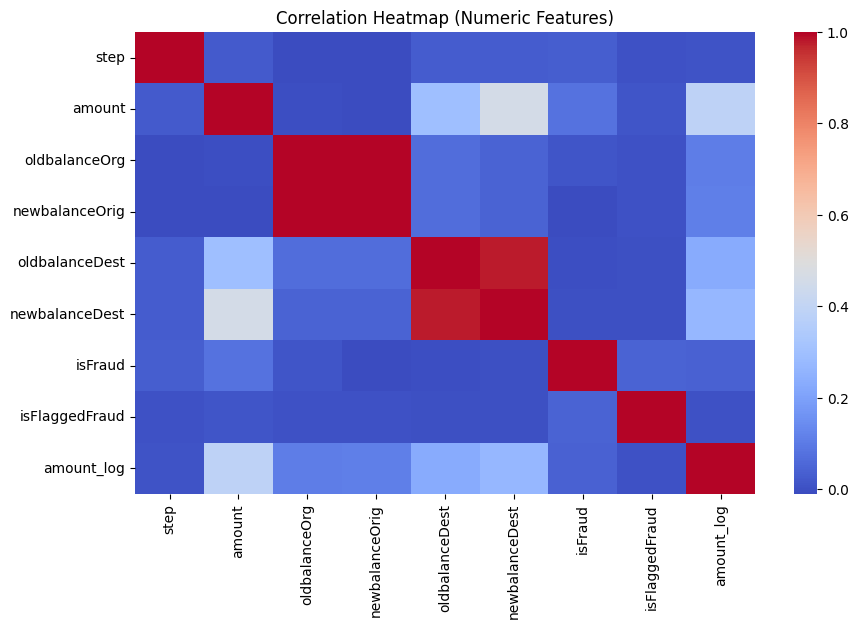

In [29]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

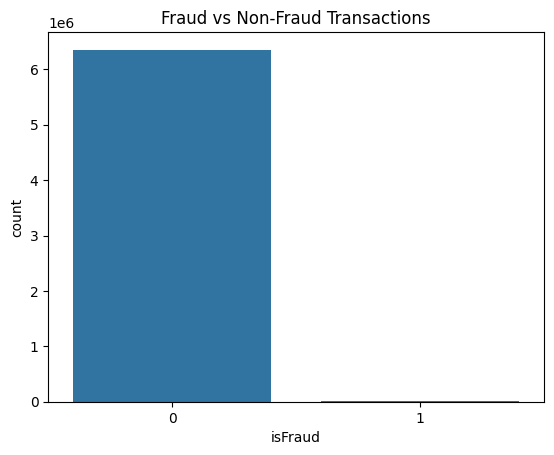

In [30]:
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

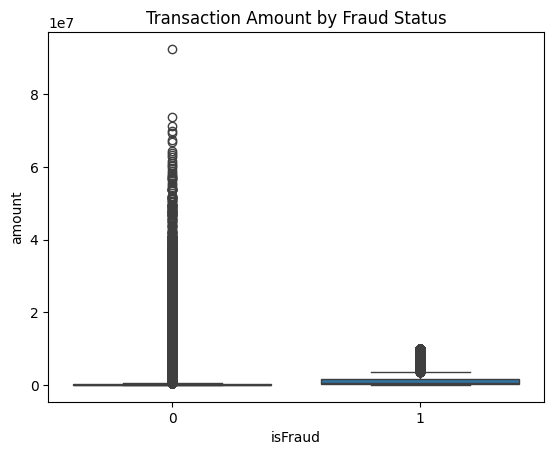

In [31]:
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title("Transaction Amount by Fraud Status")
plt.show()

In [33]:
df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [34]:
df[['balance_change_orig', 'balance_change_dest']].head()


,balance_change_orig,balance_change_dest
0,9839.64,0.0
1,1864.28,0.0
2,181.00,0.0
3,181.00,-21182.0
4,11668.14,0.0


from matplotlib import pyplot as plt
_df_0['balance_change_orig'].plot(kind='hist', bins=20, title='balance_change_orig')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['balance_change_dest'].plot(kind='hist', bins=20, title='balance_change_dest')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='balance_change_orig', y='balance_change_dest', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['balance_change_orig'].plot(kind='line', figsize=(8, 4), title='balance_change_orig')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['balance_change_dest'].plot(kind='line', figsize=(8, 4), title='balance_change_dest')
plt.gca().spines[['top', 'right']].set_visible(False)

In [35]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])


In [36]:
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
scale_weight = (len(y_train) - y_train.sum()) / y_train.sum()

model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=scale_weight,
    eval_metric='auc',
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [39]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.21      1.00      0.34      1643

    accuracy                           1.00   1272524
   macro avg       0.60      1.00      0.67   1272524
weighted avg       1.00      1.00      1.00   1272524



In [40]:
roc_auc_score(y_test, y_prob)

np.float64(0.9997098200097779)

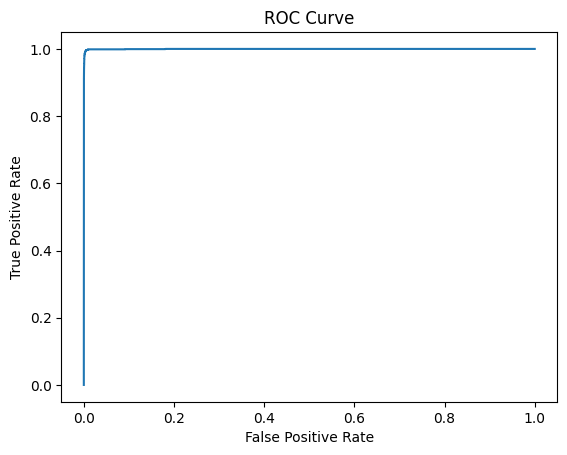

In [41]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [42]:
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).head(10)

,0
balance_change_orig,0.611391
newbalanceOrig,0.108817
newbalanceDest,0.067661
amount,0.060332
type,0.054745
amount_log,0.047357
oldbalanceOrg,0.018209
step,0.010223
balance_change_dest,0.009267
oldbalanceDest,0.006044
